# Learning objective

This notebook illustrates the kink and breather solutions of the sine-Gordon equation and demonstrates kink-kink and kink-antikink interactions.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from scipy.interpolate import griddata

# to save plots as files and download them
from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# The sine-Gordon equation

Consider the [sine-Gordon equation](https://mathworld.wolfram.com/Sine-GordonEquation.html) with normalized coefficients (dimensionless):
$$ u_{tt} - u_{xx} = - \sin u $$
subject to Neumann boundary conditions (BCs):
$$ u_x(x_\mathrm{min},t) = 0,\qquad u_x(x_\mathrm{max},t) =0, $$
on the spatial interval $x_\mathrm{min}\le x \le x_\mathrm{max}$ up to $t_\mathrm{max}$.

In [2]:
# spatial interval
xmin = -10
xmax = 10

# number of grid points in discretization
N = 500
# grid spacing
h = (xmax-xmin)/N
# the grid
xj = np.linspace(xmin,xmax,num=N,endpoint=True)

# simulation total run time
tmax = 10

## Kink

The kink solution (topological soliton) is
$$
u(x,t)=
\begin{cases}
4\tan^{-1}\left[\exp\left(\frac{x-v_0t-x_0}{\sqrt{1-v_0^2}}\right)\right],&\quad v_0 <1,\\
-\pi + 4\tan^{-1}\left[\exp\left(\frac{x-v_0t-x_0}{\sqrt{v_0^2-1}}\right)\right], &\quad v_0 >1.
\end{cases}
$$

In [3]:
# the kink (topological soliton)
def kink(x,t,x0,v0):
  if v0 < 1:
    u = 4*np.arctan(np.exp((x-v0*t-x0)/np.sqrt(1-v0**2)))
  elif v0 > 1:
    u = 4*np.arctan(np.exp((x-v0*t-x0)/np.sqrt(v0**2-1))) - np.pi
  elif v0 == 1:
    print('ERROR: kink not defined for vel. v = 1!')
  return u

The time derivative of the kink solution is
$$
u_t(x,t)=
\begin{cases}
-\frac{2v_0}{\sqrt{1-v_0^2}}\mathrm{sech}\left(\frac{x-v_0t-x_0}{\sqrt{1-v_0^2}}\right), &\quad v_0 <1,\\
-\frac{2v_0}{\sqrt{v_0^2-1}}\mathrm{sech}\left(\frac{x-v_0t-x_0}{\sqrt{v_0^2-1}}\right), &\quad v_0 >1.
\end{cases}
$$

In [4]:
# the time derivative of the kink
def kinkdt(x,t,x0,v0):
  if v0 < 1:
    ut = -2*v0/np.sqrt(1-v0**2)/np.cosh((x-v0*t-x0)/np.sqrt(1-v0**2))
  elif v0 > 1:
    ut = -2*v0/np.sqrt(v0**2-1)/np.cosh((x-v0*t-x0)/np.sqrt(v0**2-1))
  elif v0 == 1:
    print('ERROR: kink not defined for vel. v = 1!')
  return ut

Note that the anti-kink solution is the case when the argument of $\exp(\cdots)$ is multiplied by $-1$.

## Breather

The breather solution (localized mode) is
$$u(x,t)=4\tan^{-1}\left\{\frac{\sqrt{1-\omega_B^2}}{\omega_B}\sin\left[\omega_B \left(\frac{t - v_0 x}{\sqrt{1-v_0^2}}\right)\right]\mathrm{sech}\left[\sqrt{1-\omega_B^2} \left(\frac{x-v_0t-x_0}{\sqrt{1-v_0^2}}\right)\right]\right\},\qquad v_0<1,$$
with its own frequency $\omega_B$ of oscillation in the linear band gap, $0< \omega_B < 1$.

In [5]:
# the breather (localized mode)
def breather(x,t,x0,v0,wB):
  if wB <= 1:
    u = 4*np.arctan(np.sqrt(1-wB**2)/wB*np.sin(wB*(t-v0*x)/np.sqrt(1-v0**2)) \
                    /np.cosh(np.sqrt(1-wB**2)*(x-v0*t-x0)/np.sqrt(1-v0**2)))
  elif wB > 1:
    print('ERROR: breather not defined for freq. wB > 1!')
  return u

The time derivative of the breather solution is a mess. Let's compute it symbolically with [SymPy](https://www.sympy.org/en/index.html).

In [6]:
omega_B, v_0, x_0, x, t = sp.symbols('omega_B v_0 x_0 x t')
breatherdtsym = sp.diff(4*sp.atan(sp.sqrt(1-omega_B**2)/omega_B*sp.sin(omega_B*(t-v_0*x)/sp.sqrt(1-v_0**2)) \
                /sp.cosh(sp.sqrt(1-omega_B**2)*(x-v_0*t-x_0)/sp.sqrt(1-v_0**2))), t)
sp.simplify(breatherdtsym)

      ⎛                                          ⎛   __________               
      ⎜       __________                         ⎜  ╱        2                
      ⎜      ╱        2     ⎛ω_B⋅(t - v₀⋅x)⎞     ⎜╲╱  1 - ω_B  ⋅(t⋅v₀ - x + x₀
4⋅ω_B⋅⎜ω_B⋅╲╱  1 - ω_B  ⋅cos⎜──────────────⎟⋅cosh⎜────────────────────────────
      ⎜                     ⎜    _________ ⎟     ⎜            _________       
      ⎜                     ⎜   ╱       2  ⎟     ⎜           ╱       2        
      ⎝                     ⎝ ╲╱  1 - v₀   ⎠     ⎝         ╲╱  1 - v₀         
──────────────────────────────────────────────────────────────────────────────
                                             ⎛          ⎛   __________        
                                   _________ ⎜          ⎜  ╱        2         
                                  ╱       2  ⎜   2     2⎜╲╱  1 - ω_B  ⋅(t⋅v₀ -
                                ╲╱  1 - v₀  ⋅⎜ω_B ⋅cosh ⎜─────────────────────
                                             ⎜      

We can also use SymPy to verify this breather solves the sine-Gordon equation, but it takes quite a while to run the `simplify`....

In [7]:
#sp.simplify(breatherdtsym.diff(t,2) - breatherdtsym.diff(x,2) + sp.sin(breatherdtsym))

In [8]:
# lambdify the above expression for numerical evaluation
breatherdtsymlam = sp.lambdify((x,t,x_0,v_0,omega_B), breatherdtsym)
# now define the time derivative of the breather
def breatherdt(x,t,x0,v0,wB):
  if wB <= 1:
    ut = breatherdtsymlam(x,t,x0,v0,wb)
  elif wB > 1:
    print('ERROR: breather not defined for freq. wB > 1!')
  return ut

## The initial condition

Sine-Gordon is a second-order-in-time problem so it requires a second intial condition. This second initial condition could be taken to be zero but that is not true for the kinks with given $v_0$. So we use the expression above for $u_t(x,0)$.

**Choice 1:** a small amplitude harmonic wave with zero initial velocity.

In [9]:
ic_type = 'ZK65'
uic = 0.1*np.cos(np.pi*xj)
vic = 0*xj

**Choice 2:** one-kink solution.

In [10]:
ic_type = 'kink'
x0 = 4
v0 = 0.75
ic = lambda x, t: kink(x,t,-x0,v0)
ic2 = lambda x, t: kinkdt(x,t,-x0,v0)
uic = ic(xj,0)
vic = ic2(xj,0)

**Choice 3a:** two-kink linear superposition (well separated) in kink-kink configuration.

In [11]:
ic_type = 'kinkkink'
x0 = 4
v0 = 0.75
ic = lambda x, t: kink(x,t,-x0,v0) + kink(x,t,x0,-v0)
ic2 = lambda x, t: kinkdt(x,t,-x0,v0) + kinkdt(x,t,x0,-v0)
uic = ic(xj,0)
vic = ic2(xj,0)

**Choice 3b:** two-kink linear superposition (well separated) in kink-antikink configuration. Technically we should construct the antikink, add it to the kink and subtract $2\pi$, but the "hack" below works out to be the same. &#x263A;

In [12]:
ic_type = 'kinkantikink'
x0 = 4
v0 = 0.75
ic = lambda x, t: kink(x,t,-x0,v0) - kink(x,t,x0,-v0)
ic2 = lambda x, t: kinkdt(x,t,-x0,v0) - kinkdt(x,t,x0,-v0)
uic = ic(xj,0)
vic = ic2(xj,0)

**Choice 4:** breather solution.

In [13]:
ic_type = 'breather'
t0 = 0
x0 = 0
v0 = 0
wb = 0.75
ic = lambda x, t: breather(x,t,x0,v0,wb)
ic2 = lambda x, t: breatherdt(x,t,x0,v0,wb)
uic = ic(xj,t0)
vic = ic2(xj,t0)

Whichever initial condition we chose, let's plot it.

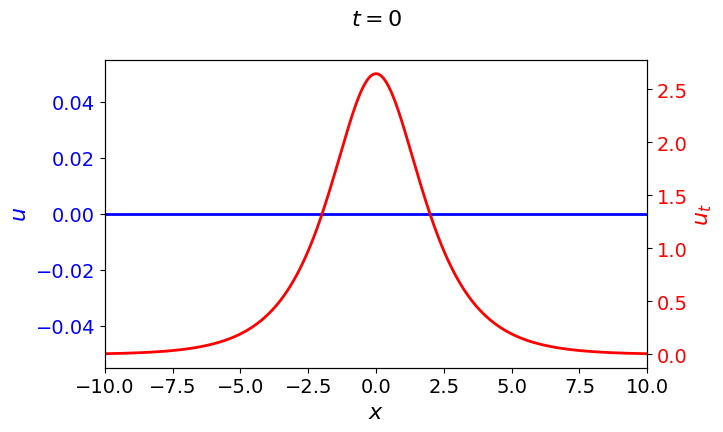

In [14]:
fig, ax1 = plt.subplots(figsize=(7,4))

# u on the left axis
ax1.plot(xj, uic, color='blue', lw=2)
ax1.set_ylabel('$u$', color='blue')
#ax1.set_ylim(0,2*np.pi)
ax1.set_xlabel('$x$')
ax1.set_xlim(xmin,xmax)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'$t=0$')

# u_t=v on the right axis
ax2 = ax1.twinx()
ax2.plot(xj, vic, color='red', lw=2)
ax2.set_ylabel('$u_t$', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Numerical solution

We have to write the second-order wave equation as an equivalent first-order _system_:
$$ \left. \begin{align} u_{t} &= v,\\ v_t &= u_{xx} - \sin u. \end{align} \right\} $$

The semi-discrete problem (using the [method of lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html)) we wish to solve is
$$ \left. \begin{align} \dot{u}_j &= v_j,\\ \dot{v}_j &= \left(\frac{u_{j+1} - 2u_j + u_{j-1}}{h^2}\right) - \sin u_j \end{align}\right\}\quad j=1,\dots,N-2, $$
so that $u_j(t) \approx u(x_j,t)$.

**Note**: the kink is not periodic, so we use Neumann BCs, $\partial u/\partial x = 0$ at $x=x_\mathrm{min}$ and $x_\mathrm{max}$, most easily implemented as $u_{-1}=u_1$ and $u_{N}=u_{N-2}$.

In [15]:
# ODE system right-hand side
def sinegordon(t,u):
  F = np.empty(2*N)

  # boundary nodes require special care
  # by definition:
  F[0] = u[N]
  F[N-1] = u[2*N-1]
  # by Neumann BCs:
  F[N] = (u[1] - 2*u[0] + u[1])/h**2 - np.sin(u[0])
  F[2*N-1] = (u[N-2] - 2*u[N-1] + u[N-2])/h**2 - np.sin(u[N-1])

  # interior nodes, per the ODE formula
  for j in range(1,N-1):
    F[j]   = u[j+N]
    F[j+N] = (u[j+1] - 2*u[j] + u[j-1])/h**2 - np.sin(u[j])

  return F

In [16]:
# concatenate the two ICs as one vector to pass to solve_ivp
uvic = np.concatenate((uic,vic))

In [17]:
# try: test different tolerances for the integrator, changing tol
tol = 1e-8

# simulate the PDE
sol = solve_ivp(fun=sinegordon,
                t_span=[0,tmax], y0=uvic,
                method='RK45', rtol=tol, atol=tol, dense_output=True)

# Results and visualization

## Static plot

First, just a quick static plot of the solution at the final time.

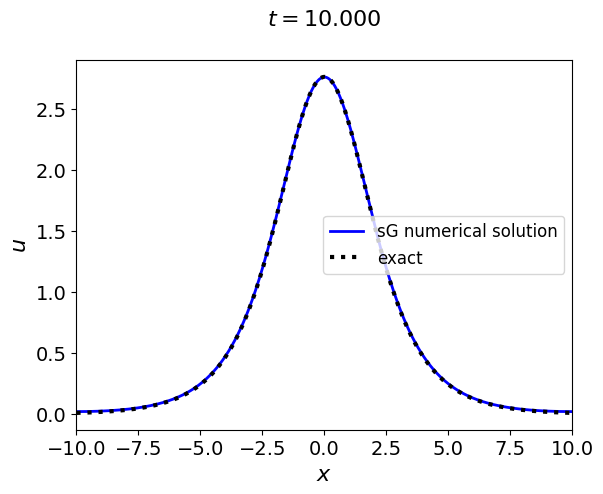

In [18]:
tplot = 10
uj = sol.sol(tplot)[0:N]

fig, ax = plt.subplots()
ax.plot(xj, uj, lw=2, color='blue', label='sG numerical solution')

if ic_type == 'kink' or ic_type == 'breather':
  ax.plot(xj, ic(xj,tplot), lw=3, color='black', ls='dotted', label='exact')
elif ic_type == 'kinkkink' or ic_type == 'kinkantikink':
  ax.plot(xj, ic(xj,tplot), lw=3, color='black', ls='dotted', label='linear superposition')

ax.set_ylabel('$u$')
#ax.set_ylim(-1,3)
ax.set_xlabel('$x$')
ax.set_xlim(xmin,xmax)
ax.set_title(f'$t=${tplot:.3f}')
ax.legend();

## Animation

Next, we visualize our results using our snazzy animation tools.

In [19]:
# define how to sample the solution in time
tnum = 100
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [20]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(xmin,xmax)
if ic_type == 'kink':
  ax.set_ylim(-0.1*np.pi,2.1*np.pi)
elif ic_type == 'kinkkink':
  ax.set_ylim(-0.1*np.pi,4.1*np.pi)
else:
  ax.set_ylim(-2.1*np.pi,2.1*np.pi)
# nice dynamic label to show time
ttl = ax.text(0.05, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol.sol(it*dt)[0:N]
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## Space-time plot

In [21]:
# define how to sample the solution in time
tnum = 200
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

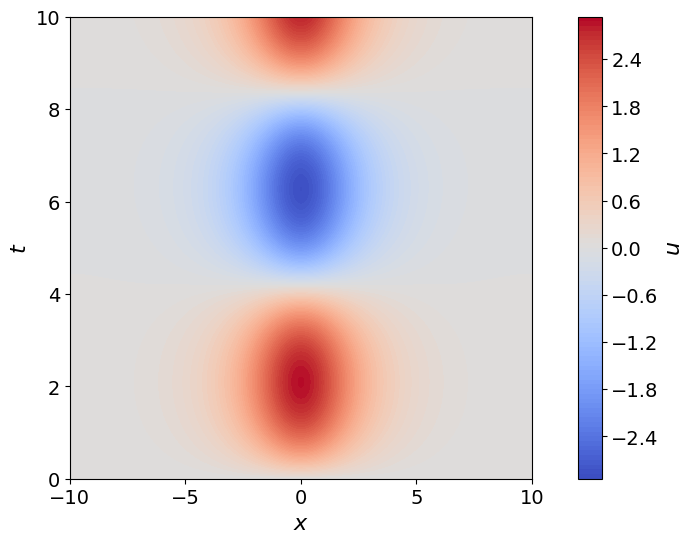

In [22]:
# make a matrix of space-time values u(x,t)
ujp = np.empty((tnum,N))
for it in range(0,tnum):
  ujp[it,:] = sol.sol(it*dt)[0:N]

# make cool plot, try also cmap='RdGy' or 'twilight_shifted'
fig, ax = plt.subplots(figsize=(12, 6))
plt.contourf(xj, tspan, ujp, 100, cmap='coolwarm')
plt.colorbar(label='$u$')
ax.set_ylim(0,tmax)
ax.set_ylabel('$t$')
ax.set_xlim(xmin,xmax)
ax.set_xlabel('$x$')
ax.set_aspect(2/1)

# Conservation properties of the solution

Recall, $v=u_t$. For steady propogation of a single kink,  the "pseudo"momentum should be more-or-less exactly conserved:
$$ \int_{x_\mathrm{min}}^{x_\mathrm{max}} -v(x,t)u_x(x,t)\,dx \approx const. \quad\text{for all $t\ge0$},$$
and also the energy ("Hamiltonian"):
$$ \int_{x_\mathrm{min}}^{x_\mathrm{max}} \frac{1}{2}\left\{[v(x,t)]^2 + \left[u_x(x,t)\right]^2\right\} + \left[ 1 - \cos u(x,t) \right] \, dx \approx const. \quad\text{for all $t\ge0$}. $$

To compute the integrals, we use the trapezoidal rule implemented in [SciPy](https://numpy.org/doc/stable/reference/generated/numpy.trapz.html) as `trapz`, and we approximate
$$ u_x(x_j,t) \approx \frac{u_{j+1}(t)-u_{j-1}(t)}{2h}. $$
At $j=N-1$ and $j=0$, we use the Neumann BCs.

Verifying these conservation properties  will give us confidence in our numerical solutions.

**Note:** However, we should be careful in interpreting these for the case of coliding and, especially, accelerating kinks.

In [23]:
# define how to sample the solution in time
tnum = N
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [24]:
# compute the momentum and energy as functions of t
momentum = np.empty(tnum)
energy = np.empty(tnum)
for it in range(0,tnum):
  uj = sol.sol(it*dt)[0:N]
  vj = sol.sol(it*dt)[N:2*N]
  uxj = ( np.concatenate((uj[1:N],[uj[N-2]])) \
          - np.concatenate(([uj[1]],uj[0:N-1])) )/(2*h)

  momentum[it] = np.trapz(-vj*uxj,xj)
  energy[it] = np.trapz(0.5*(vj**2 + uxj**2) + 1 - np.cos(uj),xj)

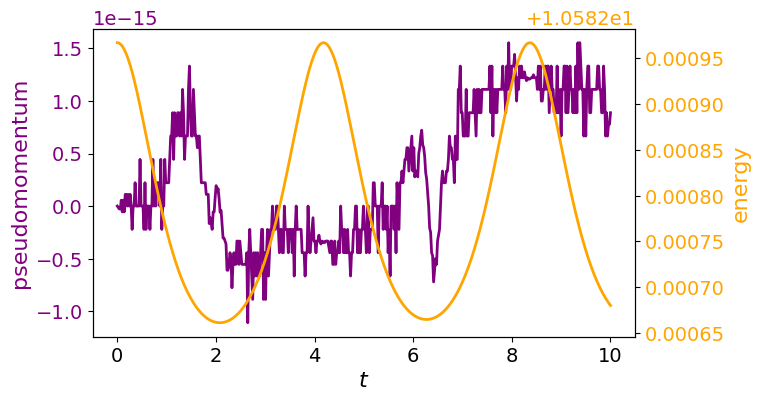

In [25]:
fig, ax1 = plt.subplots(figsize=(7,4))

# momentum on the left axis
ax1.plot(tspan, momentum, lw=2, color='purple')
ax1.set_ylabel('pseudomomentum', color='purple')
ax1.set_xlabel('$t$')
ax1.tick_params(axis='y', labelcolor='purple')

# energy on the right axis
ax2 = ax1.twinx()
ax2.plot(tspan, energy, color='orange', lw=2)
ax2.set_ylabel('energy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

In [26]:
print(energy[-1])

10.58267998899623


In [27]:
print(momentum[-1])

8.881784197001252e-16


# Ideas to explore on your own

A few ideas for interesting "computational experiments" to explore on your own are outlined here.

1.   Comparing the steady propagation of 2 individiual non-interacting kinks (or a kink-antikink pair) and attempt to determine whether a "phase shift" arises from the collision. That is, after coliding are the kinks (or kink and antikink) in the "correct" locations or did they can pushed/pulled?
2.   Implement the _exact_ kink-kink or kink-antikink (see [Remoissenet's Appendix 6C.2 &amp; 6C.4](https://link-springer-com.ezproxy.lib.purdue.edu/content/pdf/10.1007/978-3-662-03057-8_6.pdf) or [here](https://eqworld.ipmnet.ru/en/solutions/npde/npde2106.pdf)) and compare it to your numerical solution.
3.   Try different boundary conditions, such a fixed end that causes reflection of the wave at the boundary.

